In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import numpy as np
import pymc3 as pm
import scipy
%matplotlib inline

In [2]:
PATH = 'data/d.csv'

In [3]:
#　データを読み込む。 
csv = pd.read_csv(PATH)

In [4]:
csv

,plant.ID,y,alpha
0,1,0,-4.159582
1,2,0,-3.718362
2,3,0,-3.069020
3,4,0,-3.054211
4,5,0,-2.880656
5,6,2,-2.705595
6,7,1,-2.441703
7,8,1,-2.221327
8,9,0,-2.209120
9,10,1,-2.111941


In [5]:
# y列のデータを取り出す。
ys = csv['y'].values

In [6]:
# ヒストグラムを作る。
histo_ys = np.zeros(11)
for y in ys:
    histo_ys[y] += 1
print(histo_ys)
print(np.sum(histo_ys))

[  7.  10.  10.   5.  12.  11.  11.   7.  14.   9.   4.]
100.0


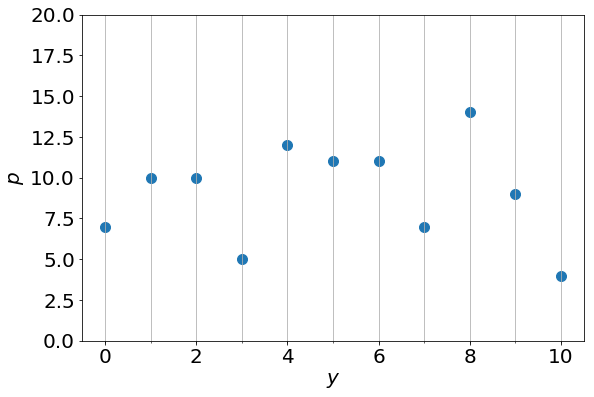

In [7]:
# ヒストグラムを描画する。
xs = np.arange(11)
plt.figure(figsize=(9,6))
plt.rcParams["font.size"] = 20
plt.scatter(xs, histo_ys, s=100)
plt.xlabel('$y$')
plt.ylabel('$p$')
plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid(which='minor')
plt.ylim(0, 20)
plt.show()

In [8]:
model = pm.Model()
with model:
    q = pm.Uniform('q', lower=0, upper=1)
    y = pm.Binomial('y', n=10, p=q, observed=ys)
    map_estimate = pm.find_MAP(model=model)
print(map_estimate['q'])

logp = -316.78, ||grad|| = 4: 100%|██████████| 5/5 [00:00<00:00, 37.39it/s]   


0.4960000053023121


In [9]:
rv = scipy.stats.binom(10, map_estimate['q'])
binom_ys = [100 * rv.pmf(k) for k in range(11)]

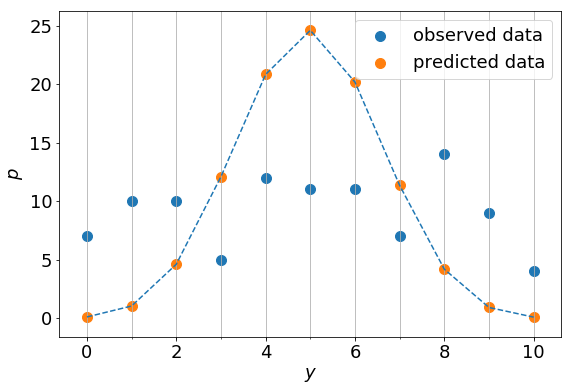

In [10]:
plt.figure(figsize=(9,6))
plt.rcParams["font.size"] = 18
plt.scatter(xs, histo_ys, s=100, label='observed data')
plt.plot(xs, binom_ys, ls='--')
plt.scatter(xs, binom_ys, s=100, label='predicted data')
plt.xlabel('$y$')
plt.ylabel('$p$')
plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid(which='minor')
plt.legend(loc='best')
plt.show()

In [11]:
model = pm.Model()
with model:
    beta = pm.Normal('beta', mu=0, tau=1.0e-2)
    tau = pm.Gamma('tau', alpha=1.0e-02, beta=1.0e-02)
    alpha = pm.Normal('alpha', mu=0, tau=tau , shape=len(ys))
    ymu = pm.math.sigmoid(beta + alpha)
    y = pm.Binomial('y', n=10, p=ymu, observed=ys)
    start = pm.find_MAP()
    step = pm.NUTS()
    trace = pm.sample(5000, start=start, step=step)
alpha.shape

logp = -48.984, ||grad|| = 0.031497: 100%|██████████| 33/33 [00:00<00:00, 1977.31it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, tau, beta]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:24<00:00, 916.21draws/s] 


Shape.0

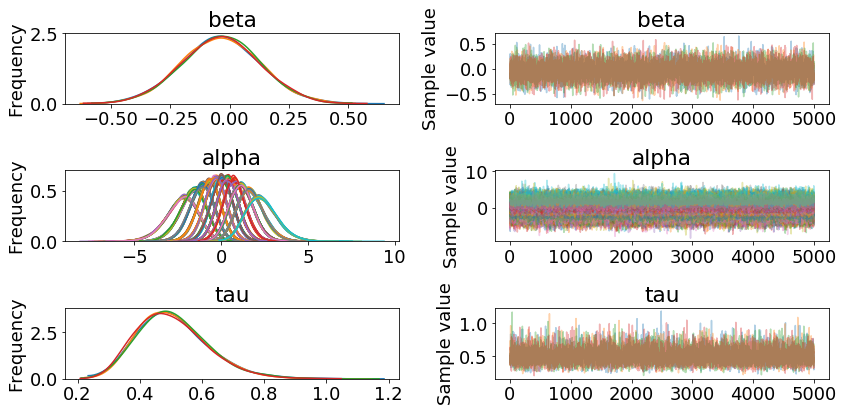

In [12]:
pm.traceplot(trace)
plt.figure(figsize=(10, 20))
plt.show()

In [13]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

In [14]:
beta_samples = trace['beta'][:]
beta_samples = beta_samples.reshape(-1, 1)
alpha_samples = trace['alpha'][:]
q_samples = sigmoid(beta_samples + alpha_samples)

In [15]:
q_samples.shape

(20000, 100)

In [16]:
rows, cols = q_samples.shape
rows = 1000
y_samples = np.zeros((cols, 11))
for col in range(cols): 
    for row in range(rows):
        rv = scipy.stats.binom(10, q_samples[row, col])
        y_samples[col] += [rv.pmf(k) for k in range(11)]
    y_samples[col] /= rows
pred_y = np.sum(y_samples, axis=0)

In [17]:
pred_y.shape

(11,)

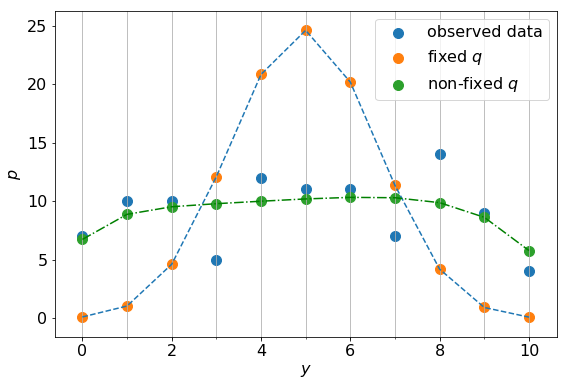

In [18]:
plt.figure(figsize=(9,6))
plt.rcParams['font.size'] = 16
plt.scatter(xs, histo_ys, s=100, label='observed data')

plt.plot(xs, binom_ys, ls='--')
plt.scatter(xs, binom_ys, s=100, label='fixed $q$')

plt.xlabel('$y$')
plt.ylabel('$p$')


plt.plot(xs, pred_y, ls='-.', c='g')
plt.scatter(xs, pred_y, s=100, label='non-fixed $q$')

plt.gca().xaxis.set_minor_locator(tick.MultipleLocator(1))
plt.grid(which='minor')
plt.legend(loc='best')
plt.show()

In [19]:
pm.summary(trace).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
beta,-0.04,0.16,0.00,-0.36,0.30,10616.93,1.0
alpha__0,-2.29,0.91,0.01,-4.12,-0.62,17899.08,1.0
alpha__1,-2.28,0.90,0.01,-4.12,-0.59,18482.80,1.0
alpha__2,-2.29,0.89,0.01,-4.07,-0.60,17428.73,1.0
alpha__3,-2.29,0.91,0.01,-4.07,-0.54,18997.10,1.0
alpha__4,-2.28,0.90,0.01,-4.08,-0.60,19585.26,1.0
alpha__5,-1.13,0.69,0.01,-2.48,0.22,19151.93,1.0
alpha__6,-1.63,0.76,0.01,-3.15,-0.18,18996.09,1.0
alpha__7,-1.63,0.77,0.01,-3.20,-0.23,20073.51,1.0
alpha__8,-2.28,0.90,0.01,-4.10,-0.61,17407.60,1.0
